# Solving a calendar puzzle

This notebook accompanies this [blog post](https://metterklume.github.io/puzzle/2024/12/24/calendar-puzzle.html) and is intended to be read in parallel.

We solve a calendar puzzle where pieces have to be placed in a grid to show a certain date.

The code can be readily adapted to any "pentomino"-type puzzle by altering the list of pieces and initial grid.

<img src="./calendar_set.jpg" alt="example" width="400" style="display: block; margin: 0 auto;"/>

## Plotting
Plotting pieces and solutions is very useful for debugging.

So it is best to get to this out of the way in the beginning.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(grid_size, squares=None, grid=None, fig_size_inches=None):
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the grid
    for i in range(grid_size):
        for j in range(grid_size):
            ax.add_patch(plt.Rectangle((i, j), 1, 1, edgecolor='grey', facecolor='lightgrey'))

    # Plot the selected squares in a different color
    if squares is None and grid is not None:
        squares = np.argwhere(grid)
    for square in squares:
        (x,y) = square
        ax.add_patch(plt.Rectangle((y,grid_size-1-x), 1, 1, edgecolor='#CE2C10', facecolor='#E67C7C'))

    # Set limits and aspect ratio
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal', adjustable='box')

    # Hide axes
    ax.axis('off')
    if fig_size_inches is not None:
        fig.set_size_inches((fig_size_inches,fig_size_inches))
    else:
        fig.set_size_inches((1,1))
    # Show plot
    plt.show()

In [4]:
def plot_solution(constraints, solution, initial_grid):
    brows, bcols = np.where(initial_grid)
    blocked = [i*7+j for (i,j) in zip(brows,bcols)]
    blocked = [t for t in blocked if t not in (6,13,45,46,47,48)]
    # Create a figure and axis
    fig, ax = plt.subplots()
    grid_size=7
    # Plot the grid
    for i in range(grid_size):
        for j in range(grid_size):
            ax.add_patch(plt.Rectangle((i, j), 1, 1, edgecolor='grey', facecolor='lightgrey'))

    for (i,j) in zip((0,1,6,6,6,6),(6,6,3,4,5,6)):
        ax.add_patch(plt.Rectangle((j,grid_size-1-i), 1, 1, color='white'))

    for b in blocked:
        ax.add_patch(plt.Rectangle((b%7,grid_size-1-(b//7)), 1, 1, fill=None, hatch='///'))

    for r in constraints[solution]:
        squares = [(x//7,x%7) for x in np.where(r[:49])[0]]
        color = "C" + str(np.where(r[49:])[0][0])
        for square in squares:
            (x,y) = square
            ax.add_patch(plt.Rectangle((y,grid_size-1-x), 1, 1, color=color))

    # Set limits and aspect ratio
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal', adjustable='box')
    # Hide axes
    ax.axis('off')
    fig.set_size_inches((4,4))
    fig.tight_layout()

    # Show plot
    plt.show()

## Add pieces
We manually create arrays for each of the eight pieces.

Then we add create all possible variants by rotating 90 degrees and flipping. 

Finally we plot all the variants in one big grid and check if there's anything missing.

In [10]:
import numpy as np

N = np.array([[1, 1, 0, 0],
            [0, 1, 1, 1]], dtype=np.int32)

V = np.array([[1, 0, 0],
            [1, 0, 0],
            [1, 1, 1]], dtype=np.int32)

Z = np.array([[1, 1, 0],
            [0, 1, 0],
            [0, 1, 1]], dtype=np.int32)

U = np.array([[1, 0, 1],
              [1, 1, 1]], dtype=np.int32)

Y = np.array([[0, 1, 0, 0],
              [1, 1, 1, 1]], dtype=np.int32)

P = np.array([[1, 1, 0],
              [1, 1, 0],
              [1, 0, 0]], dtype=np.int32)

L = np.array([[1, 0],
              [1, 0],
              [1, 0],
              [1, 1]], dtype=np.int32)

O = np.array([[1, 1],
              [1, 1],
              [1, 1]], dtype=np.int32)

In [11]:
def crop(piece):
    """Crop the grid to the smallest rectangle containing all the 1's"""
    allx, ally = np.where(piece)
    return piece[min(allx):max(allx)+1, min(ally):max(ally)+1]


def apply_symmetry(piece):
    """Take a piece array and return a list of its unique 90 degree rotations and reflections"""
    ways = []
    for i in range(0,4):
        R = crop(np.rot90(piece, i))
        if not any(R.shape==x.shape and (R==x).all() for x in ways):
            ways += [R]

    piece = np.fliplr(piece)
    for i in range(0,4):
        R = crop(np.rot90(piece, i))
        if not any(R.shape==x.shape and (R==x).all() for x in ways):
            ways += [R]
    return ways

In [12]:
# Check the number of variants for a piece
len(apply_symmetry(P))

8

In [13]:
pieces = (N,V,Z,U,Y,P,L,O)
allpieces, labels = [], []

##allpieces is a list of all unique pieces. the labels are the indices (0-7)of the original piece
for label,piece in enumerate(pieces):
    ways = apply_symmetry(piece)
    allpieces += ways
    labels += [label]*len(ways)

In [16]:
big = np.zeros((8*5,8*5),np.int32)
counters = [0]*8
for piece,label in zip(allpieces,labels):
    ppiece = np.pad(piece,((5-piece.shape[0],0),(5-piece.shape[1],0)))
    big[label*5:(label+1)*5,counters[label]*5:(counters[label]+1)*5] = ppiece
    counters[label] += 1

big=crop(big)
big.shape

(39, 39)

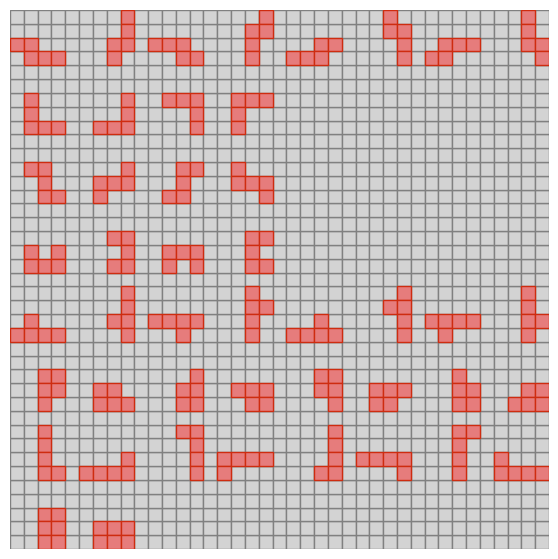

In [17]:
plot_grid(39,grid=big,fig_size_inches=7)

## Create initial grid

We create a 7x7 grid with 6 squares blocked out. These squares are not available for the pieces.

We then block out 2 more squares with the given month (1-12) and day (1-31) marked as in the photograph of the puzzle. These squares must  be left exposed in the final solution so again they are unavailable for the pieces.

In [18]:
def create_initial_grid(month=None, day=None):
    """The initial grid as a 7x7 array with 1's showing squares that are blocked out.
       6 squares are always blocked.
       We add 2 squares with the given month (1-12) and day (1-31) marked as in the 
       photograph of the puzzle."""
    initial_grid = np.array([[0, 0, 0, 0, 0, 0, 1],
                            [0, 0, 0, 0, 0, 0, 1],
                            [0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 0, 0, 0, 0],
                            [0, 0, 0, 1, 1, 1, 1]], dtype=np.int32)
    if month is not None:
        i = (month-1) // 6
        j = (month-1)%6
        initial_grid[i,j]=1
    if day is not None:
        i = ((day-1) // 7) + 2
        j = (day-1)%7
        initial_grid[i,j]=1
    return initial_grid

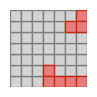

In [20]:
initial_grid = create_initial_grid(month=12, day=25)
plot_grid(7,grid=initial_grid)

## Create the matrix M

We construct the master matrix $M$ that encoded all the constraints of the puzzle. 

For each piece variant we loop over all valid positions. For each such combination, we create a row where the 1's correspond to the squares that covered and the type of the piece.

All these rows taken together, form $M$.

In [21]:
brows, bcols = np.where(initial_grid)
blocked = set(i*7+j for (i,j) in zip(brows,bcols))

def make_rows(piece, blocked):
    """
    Slide the piece in the 7x7 grid and return the rows that correspond to valid moves.
    A valid move is one that does not overlap with any of the blocked squares.
    Each row is a 49-bit array with 1's in the squares that are covered by the piece.
    """
    x_max, y_max = piece.shape
    allx, ally = np.where(piece)
    rows = []
    for i in range(7-x_max+1):
        for j in range(7-y_max+1):
            squares = [(i+x,j+y) for (x,y) in zip(allx,ally)]
            if any(7*a+b in blocked for (a,b) in squares):
                continue
            squares = [7*a+b for (a,b) in squares]
            row = np.zeros(49, dtype=np.int32)
            row[squares] = 1
            rows.append(row)

    return rows

In [23]:
M = []
for label, piece in zip(labels, allpieces):
    rows = make_rows(piece, blocked)
    suffix = [0]*8
    suffix[label] = 1
    rows = [np.hstack((row,suffix)) for row in rows]
    M += rows

M = np.array(M, dtype=np.int32)

In [24]:
M.shape

(782, 57)

## Algorithm X

We use a backtracking algorithm for the *exact cover* that $M$ 
represents. 

We need a to find a subset of non-intersecting rows such that taken together they *cover* all the columns. In other words, no two rows in the subset share a $1$ in the same column. And for any column, there is a row in the subset with a $1$ there.

The arguments `keep_rows` and `keep_cols` are boolean arrays. Entries are set to False as the corresponding row/column is removed.

In [34]:
def solve(M, keep_rows, keep_cols, working_solution):
    """
    keep_rows[i] = True if the move in row i can be made, else False
    keep_cols[j] = True if the square of column j is empty or the piece is available, else False
    
    working_solution is the current list of moves (row indices)
    n = 49 is the number of squares in the grid, hardcoded for now
    """
    n = 49
    #If all squares are covered, we have a solution
    if not keep_cols[:n].any():
        print( "success!", working_solution[1:])
        return True
    #If at least one square cannot be covered by a square,
    #we have reached a dead-end. 
    elif not M[keep_rows].sum(axis=0)[:n][keep_cols[:n]].all():
        return None
    
    #We only consider the rows that intersect the first remaining column
    #This automatically discards permutations of the pieces
    leftrows = np.where(M[:,np.where(keep_cols)[0][0]])[0]
    for r in leftrows:
        if not keep_rows[r]:
            continue

        new_keep_rows, new_keep_cols, new_solution = keep_rows.copy(), keep_cols.copy(), working_solution.copy()
        new_keep_rows[r] = False
        cols = np.where(M[r])[0]
        for c in cols:
            #remove all squares covered by the piece and the piece itself
            new_keep_cols[c] = False
            #remove all moves that overlap with the piece that we have just placed
            for rr in np.where(M[:,c])[0]:
                new_keep_rows[rr] = False
        new_solution.append(r)
        solve(M, new_keep_rows, new_keep_cols, new_solution)
        
    return None

In [35]:
# A technicality: we need to remove columns that are all 0's
# These are squares that are blocked out in the initial grid.
# Otherwis the algorithm will try to cover all these columns
# and will fail to find a solution.
chop_cols = [i for (i,c) in enumerate(M.T) if not c.any()]
keep_cols = [c not in chop_cols for c in range(M.shape[1])]
keep_rows = [True]*M.shape[0]
len(keep_cols),len(keep_rows)

(57, 782)

In [ ]:
solve(M,np.array(keep_rows,dtype=np.bool_),np.array(keep_cols,dtype=np.bool_),[-1])

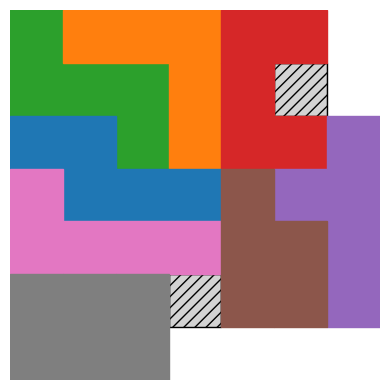

In [37]:
plot_solution(M,[240, 156, 321, 6, 425, 739, 601, 781],initial_grid)

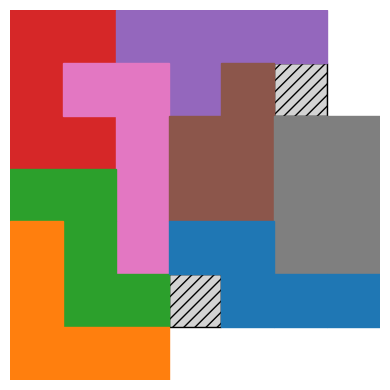

In [38]:
plot_solution(M,[317, 430, 657, 509, 756, 203, 140, 14],initial_grid)

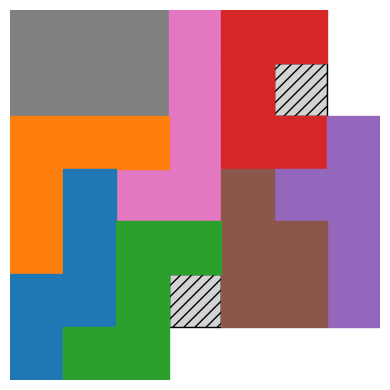

In [39]:
plot_solution(M,[763, 685, 321, 178, 425, 28, 601, 239],initial_grid)

Collect all solutions in a list.

In [41]:
def allsolve(M, keep_rows, keep_cols):
    solutions = []
    def solve(M, keep_rows, keep_cols, working_solution):
        """
        keep_rows[i] = True if the move in row i can be made, else False
        keep_cols[j] = True if the square of column j is empty or the piece is available, else False
        
        working_solution is the current list of moves (row indices)
        n = 49 is the number of squares in the grid, hardcoded for now
        """
        n = 49
        #If all squares are covered, we have a solution
        if not keep_cols[:n].any():
            print( "success!", working_solution)
            solutions.append(working_solution)
            return True
        #If at least one square cannot be covered by a square,
        #we have reached a dead-end. 
        elif not M[keep_rows].sum(axis=0)[:n][keep_cols[:n]].all():
            return None
        
        #We only consider the rows that intersect the first remaining column
        #This automatically discards permutations of the pieces
        leftrows = np.where(M[:,np.where(keep_cols)[0][0]])[0]
        for r in leftrows:
            if not keep_rows[r]:
                continue

            new_keep_rows, new_keep_cols, new_solution = keep_rows.copy(), keep_cols.copy(), working_solution.copy()
            new_keep_rows[r] = False
            cols = np.where(M[r])[0]
            for c in cols:
                #remove all squares covered by the piece and the piece itself
                new_keep_cols[c] = False
                #remove all moves that overlap with the piece that we have just placed
                for rr in np.where(M[:,c])[0]:
                    new_keep_rows[rr] = False
            new_solution.append(r)
            solve(M, new_keep_rows, new_keep_cols, new_solution)
            
        return None
    
    solve(M,np.array(keep_rows,dtype=np.bool_),np.array(keep_cols,dtype=np.bool_),[])
    return solutions

In [ ]:
solutions =allsolve(M,np.array(keep_rows,dtype=np.bool_),np.array(keep_cols,dtype=np.bool_))

## Exploring the space of solutions for each date.

Find the list of solutions for all combinations of month and day.

**Warning** 

The code below takes ~ 20 min on a Macbook M1. It can be sped up significantly by using Numba but that needs some adaptation. Exercise for the reader!

In [ ]:
allsolutions = []
for m in range(1,13):
    for d in range(1,32):
        initial_grid = create_initial_grid(month=m, day=d)
        brows, bcols = np.where(initial_grid)
        blocked = set(i*7+j for (i,j) in zip(brows,bcols))
        M = []
        for label, piece in zip(labels, allpieces):
            rows = make_rows(piece, blocked)
            suffix = [0]*8
            suffix[label] = 1
            rows = [np.hstack((row,suffix)) for row in rows]
            M += rows

        M = np.array(M, dtype=np.int32)
        chop_cols = [i for (i,c) in enumerate(M.T) if not c.any()]
        keep_cols = [c not in chop_cols for c in range(M.shape[1])]
        keep_rows = [True]*M.shape[0]
        solutions = allsolve(M,np.array(keep_rows,dtype=np.bool_),np.array(keep_cols,dtype=np.bool_))

        allsolutions.append((m,d,solutions))


In [126]:
len(allsolutions)

372

In [ ]:
nsols = [len(s[2]) for s in allsolutions]
plt.hist(nsols,bins=20)

/var/folders/n7/bnpg49t95cg1qn6lkw01wg_h0000gn/T/ipykernel_53235/1605390099.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid') # nice and clean grid


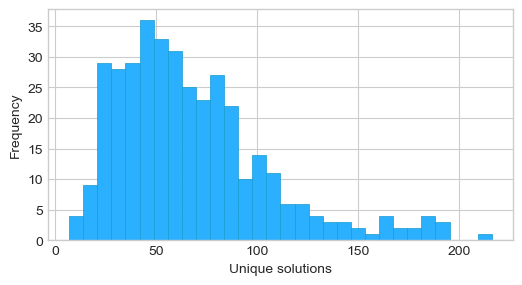

In [197]:
plt.figure(figsize=(6,3)) # Make it 14x7 inch
plt.style.use('seaborn-whitegrid') # nice and clean grid
plt.hist(nsols, bins=30, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel('Unique solutions') 
plt.ylabel('Frequency') 
plt.show()